# Phishing URL Classification Project

In [1]:
# Data handling
import numpy as np
import pandas as pd
from scipy.io import arff

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import optuna
from joblib import dump

In [2]:
# Load an arff dataset
data, meta = arff.loadarff("Training Dataset.arff")
# Convert to pandas DataFrame
data = pd.DataFrame(data)
# print the information stored in meta (in meta info about the dataset is stored)
print(meta)

Dataset: phishing
	having_IP_Address's type is nominal, range is ('-1', '1')
	URL_Length's type is nominal, range is ('1', '0', '-1')
	Shortining_Service's type is nominal, range is ('1', '-1')
	having_At_Symbol's type is nominal, range is ('1', '-1')
	double_slash_redirecting's type is nominal, range is ('-1', '1')
	Prefix_Suffix's type is nominal, range is ('-1', '1')
	having_Sub_Domain's type is nominal, range is ('-1', '0', '1')
	SSLfinal_State's type is nominal, range is ('-1', '1', '0')
	Domain_registeration_length's type is nominal, range is ('-1', '1')
	Favicon's type is nominal, range is ('1', '-1')
	port's type is nominal, range is ('1', '-1')
	HTTPS_token's type is nominal, range is ('-1', '1')
	Request_URL's type is nominal, range is ('1', '-1')
	URL_of_Anchor's type is nominal, range is ('-1', '0', '1')
	Links_in_tags's type is nominal, range is ('1', '-1', '0')
	SFH's type is nominal, range is ('-1', '1', '0')
	Submitting_to_email's type is nominal, range is ('-1', '1')
	

In [3]:
# Convert byte string columns to integers for model compatibility
for col in data.columns:
    data[col] = data[col].apply(lambda x :int(x.decode('utf-8')))

data.head(5)

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [4]:
# Check for missing values
print("Missing values per column:\n", data.isnull().sum())

# Verify data types are as expected
print("Data types:\n", data.dtypes)

# Note: Since data is already clean and normalized, no further action is needed.

Missing values per column:
 having_IP_Address              0
URL_Length                     0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page         0
Statistical_rep

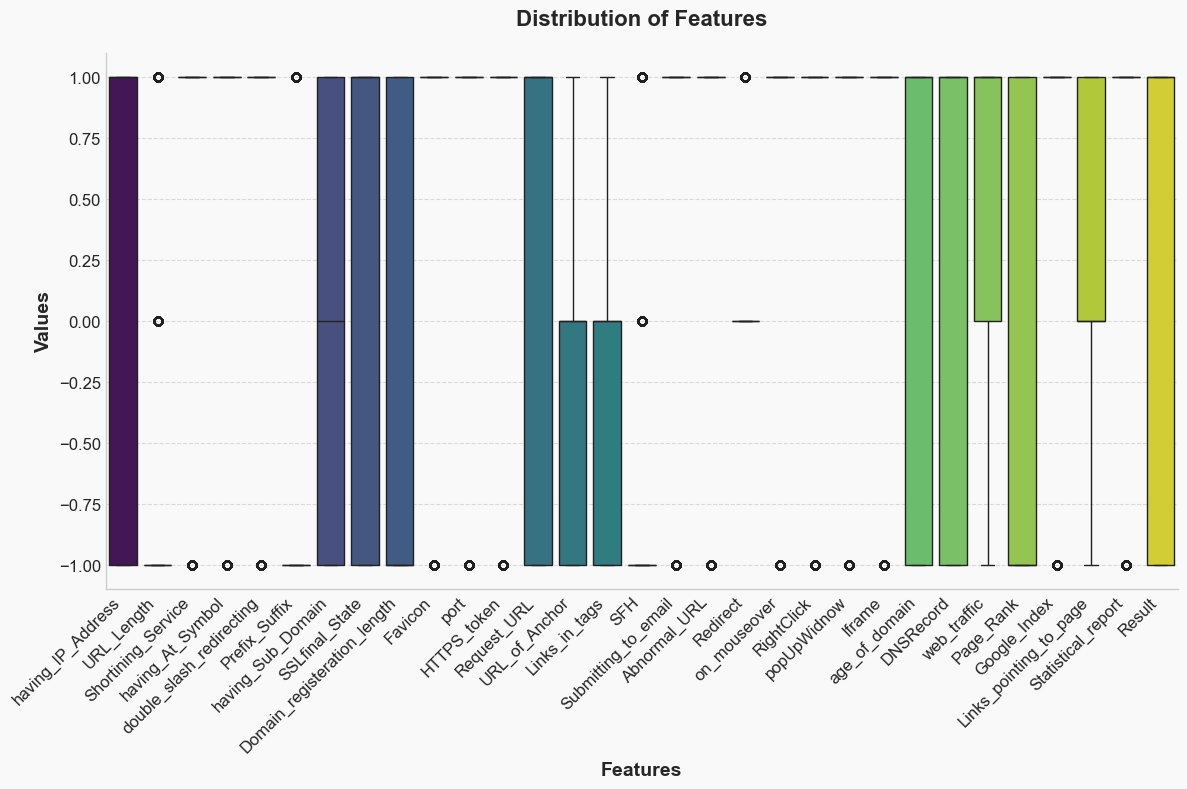

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette("viridis", n_colors=len(data.columns))
fig, ax = plt.subplots(figsize=(12, 8), facecolor='#f9f9f9')
sns.boxplot(data=data, palette=colors, ax=ax)
ax.set_facecolor('#f9f9f9')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Features', fontsize=14, fontweight='bold')
plt.ylabel('Values', fontsize=14, fontweight='bold')
plt.title('Distribution of Features', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

### Data Splitting and Label Transformation

We begin by separating the dataset into features (`X`) and the target variable (`y`).  
Next, we split the data into training and testing sets using an 80-20 split.  
Since the original dataset contains class labels as `-1` and `1`, we convert all `-1` labels to `0` to conform to a standard binary classification format (especially for XGBoost).


In [6]:
X = data.drop('Result', axis = 1)
y = data['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Replace class label -1 with 0 in both training and test labels
# This ensures binary classification labels are 0 and 1
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)


In [7]:
def train_evaluate_model(model,X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict y_train and y_test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Traning accuracy and testing accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Evaluation
    print(f"📌 Model: {model.__class__.__name__}")
    print(f"✅ Training Accuracy: {train_acc:.4f}")
    print(f"✅ Testing Accuracy: {test_acc:.4f}")
    print("📊 Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("-" * 60)

In [8]:
train_evaluate_model(LogisticRegression(),X_train, X_test, y_train, y_test)

📌 Model: LogisticRegression
✅ Training Accuracy: 0.9300
✅ Testing Accuracy: 0.9245
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       956
           1       0.93      0.94      0.93      1255

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211

------------------------------------------------------------


In [9]:
train_evaluate_model(RandomForestClassifier(),X_train, X_test, y_train, y_test)

📌 Model: RandomForestClassifier
✅ Training Accuracy: 0.9906
✅ Testing Accuracy: 0.9661
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.97      0.96      0.97      2211
weighted avg       0.97      0.97      0.97      2211

------------------------------------------------------------


In [10]:
train_evaluate_model(DecisionTreeClassifier(),X_train, X_test, y_train, y_test)

📌 Model: DecisionTreeClassifier
✅ Training Accuracy: 0.9906
✅ Testing Accuracy: 0.9584
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       956
           1       0.96      0.97      0.96      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211

------------------------------------------------------------


In [11]:
train_evaluate_model(KNeighborsClassifier(),X_train, X_test, y_train, y_test)

📌 Model: KNeighborsClassifier
✅ Training Accuracy: 0.9655
✅ Testing Accuracy: 0.9408
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       956
           1       0.94      0.95      0.95      1255

    accuracy                           0.94      2211
   macro avg       0.94      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211

------------------------------------------------------------


In [12]:
train_evaluate_model(SVC(probability=True),X_train, X_test, y_train, y_test)

📌 Model: SVC
✅ Training Accuracy: 0.9541
✅ Testing Accuracy: 0.9471
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       956
           1       0.94      0.97      0.95      1255

    accuracy                           0.95      2211
   macro avg       0.95      0.94      0.95      2211
weighted avg       0.95      0.95      0.95      2211

------------------------------------------------------------


In [13]:
train_evaluate_model( MLPClassifier(max_iter = 500),X_train, X_test, y_train, y_test)

📌 Model: MLPClassifier
✅ Training Accuracy: 0.9886
✅ Testing Accuracy: 0.9674
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.97      0.96      0.97      2211
weighted avg       0.97      0.97      0.97      2211

------------------------------------------------------------


In [14]:
train_evaluate_model( XGBClassifier(use_label_encoder=False, eval_metric='logloss'),X_train, X_test, y_train, y_test)

📌 Model: XGBClassifier
✅ Training Accuracy: 0.9871
✅ Testing Accuracy: 0.9706
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

------------------------------------------------------------


C:\Users\intel computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:59:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('mlp', MLPClassifier(max_iter=500)),
    ('svm', SVC(probability=True))
]

# Define the Stacking ensemble model
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

In [ ]:
train_evaluate_model( stack_model,X_train, X_test, y_train, y_test)

C:\Users\intel computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:59:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\intel computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:59:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\intel computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:59:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\intel computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserW

In [ ]:
# Removed the following two features due to lack of free, reliable data sources (Required paid api):
# - PageRank
# - Google Index
X = data.drop(['Result', 'Page_Rank', 'Google_Index'], axis = 1)
y = data['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Replace class label -1 with 0 in both training and test labels
# This ensures binary classification labels are 0 and 1
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

X.head(5)


In [ ]:
# Optuna automatically finds the best parameters through intelligent trial selection.
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200, step=100),
        "max_depth": trial.suggest_int("max_depth", 4, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 2),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": 1,  # If class imbalance exists, tune this
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }


    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Best model training
best_params = study.best_params
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)




In [ ]:
# Save model
dump(best_model, "xgboost_best_model.joblib")